In [1]:
# !pip install git+https://github.com/serge-m/pytorch-nn-tools.git@v0.3.3
# !pip install torch_lr_finder==0.2.1

In [2]:
import os
from argparse import ArgumentParser, Namespace

import pytorch_lightning as pl
import torch
import torch.nn.parallel
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import LearningRateLogger
import numpy as np

from model_base import ModelBase, get_main_model

import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
from typing import Dict, List, Callable, Union
from pathlib import Path
import json
import time

from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep



import pytorch_nn_tools as pnt
from pytorch_nn_tools.visual import ImgShow, tfm_vis_img, UnNormalize_, imagenet_stats
from pytorch_nn_tools.train.metrics.processor import mod_name_train, mod_name_val, Marker
from pytorch_nn_tools.train.metrics.processor import MetricAggregator, MetricLogger, MetricType
from pytorch_nn_tools.train.progress import ProgressTracker
from pytorch_nn_tools.convert import map_dict
from pytorch_nn_tools.train.metrics.history_condition import HistoryCondition
from pytorch_nn_tools.train.checkpoint import CheckpointSaver

In [3]:
ish = ImgShow(ax=plt)

In [4]:
def _train_dataset(path):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    train_dir = os.path.join(path, 'train')
    train_dataset = datasets.ImageFolder(
        train_dir,
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    return train_dataset


def _val_dataset(path):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
    val_dir = os.path.join(path, 'val')
    dataset = datasets.ImageFolder(val_dir, transforms.Compose(
        [transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), normalize, ]))
    return dataset

In [5]:
num_workers = 8

batch_size_train = 2
batch_size_val = 2
device = 'cpu'

batch_size_train = 128
batch_size_val = 16
device = 'cuda'


data_path = "data/imagewoof2-320/"

train_dataloader = torch.utils.data.DataLoader(
        dataset=_train_dataset(data_path),
        batch_size=batch_size_train,
        shuffle=True, 
        num_workers=num_workers,
    )
    
val_dataloader = torch.utils.data.DataLoader(
        dataset=_val_dataset(data_path),
        batch_size=batch_size_val,
        shuffle=False,
        num_workers=num_workers,
    )



In [6]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [7]:
from tqdm import tqdm
import datetime


In [8]:
def to_device(batch, device):
    return batch.to(device)



In [9]:
from fastprogress.fastprogress import master_bar, progress_bar

In [10]:

class PBars:
    def __init__(self):
        self._main = None
        self._second = None
        
    def main(self, it, **kwargs):
        self._main = master_bar(it, **kwargs)
        return self._main
    
    def secondary(self, it, **kwargs):
        if self._main is None:
            raise RuntimeError("Cannot instantiate secondary progress bar. The main progress bar is not set.")
        self._second = progress_bar(it, parent=self._main, **kwargs)
        return self._second
        
    def main_comment(self, comment):
        self._main.main_bar.comment = comment

In [11]:
def now_as_str():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d_%H%M%s_%f")

class DummyLogger:
    def debug(self, *args):
        print(*args)


class TrainerIO:
    def __init__(self, log_dir: Union[Path, str], experiment_name: str, checkpoint_condition: Callable[[MetricType], bool]):
        self.log_dir = Path(log_dir)
        self.experiment_name = experiment_name
        self.path_experiment = self.log_dir.joinpath(experiment_name)
        self.path_checkpoints = self.path_experiment.joinpath("checkpoints")
        self.checkpoint_saver = CheckpointSaver(self.path_checkpoints, logger=DummyLogger())
        self.checkpoint_condition = checkpoint_condition
    
    def create_metric_logger(self):
        path_logs = self.path_experiment.joinpath(f"{self.experiment_name}_{now_as_str()}")
        metric_logger = MetricLogger(path_logs)
        return metric_logger
    
    def load_last(self, start_epoch: int, end_epoch: int, model, optimizer, scheduler) -> int:
        last = self.checkpoint_saver.find_last(start_epoch, end_epoch)
        if last is not None:
            print(f"found pretrained results for epoch {last}. Loading...")
            self.checkpoint_saver.load(model, optimizer, scheduler, last)
            return last + 1
        else:
            return start_epoch
    
    def save_checkpoint(self, metrics: MetricType, model, optimizer, scheduler, epoch):
        if self.checkpoint_condition(metrics): 
            self.checkpoint_saver.save(model, optimizer, scheduler, epoch)
    

In [12]:
class Trainer:
    def __init__(self, device, trainer_io: TrainerIO,
                continue_training: bool = False):
        self.device = device
        self.continue_training = continue_training
        self.trainer_io = trainer_io
        self.pbars = PBars()
        
        
    def fit(self, model, optimizer, scheduler, start_epoch, end_epoch):
        metric_logger = self.trainer_io.create_metric_logger()
        
        model = model.to(self.device)
        
        if self.continue_training:
            start_epoch = self.trainer_io.load_last(start_epoch, end_epoch, model, optimizer, scheduler)

        progr_train = ProgressTracker()
        
        for epoch in self.pbars.main(range(start_epoch, end_epoch)):
            metric_aggregator = MetricAggregator()
            self.train_epoch(
                train_dataloader, progr_train,
                model, optimizer, scheduler,  
                metric_proc=mod_name_train+metric_aggregator+metric_logger,
                pbars=self.pbars,
                report_step=10,
                tb_writer=metric_logger.writer
            )
            self.validate_epoch(
                val_dataloader,
                model,  
                metric_proc=mod_name_val+metric_aggregator+metric_logger,
                pbars=self.pbars,
                
            )
            
            aggregated = map_dict(metric_aggregator.aggregate(), key_fn=lambda key: f"avg.{key}")
            metric_logger({
                **aggregated, 
                **{f"lr_{i}": lr for i, lr in enumerate(scheduler.get_last_lr())},
                Marker.EPOCH: epoch,
            })
            self.pbars.main_comment(f"{aggregated}")
            
            
                        
            self.trainer_io.save_checkpoint(aggregated, model, optimizer, scheduler, epoch)
            
        metric_logger.close()
            
    def train_epoch(self, data_loader, progr, model, optimizer, scheduler, metric_proc, pbars, report_step=1,
                   tb_writer=None):
        model.train()
                
        for batch_idx, (images, target) in enumerate(progr.track(pbars.secondary(data_loader))):
            optimizer.zero_grad()
            
            images = to_device(images, self.device)
            target = to_device(target, self.device)
            
            output = model(images)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            if progr.cnt_total_iter % report_step == 0:
                with torch.no_grad():
                    acc1, acc5 = accuracy(output, target, topk=(1, 5))

                metric_proc({
                    'loss': loss, 'acc1': acc1, 'acc5': acc5, Marker.ITERATION: progr.cnt_total_iter,
                    **{f"lr_{i}": lr for i, lr in enumerate(scheduler.get_last_lr())},
                })
                
            if batch_idx == 0:   
                if tb_writer:
                    vis = images.detach().clone()
                    for v in vis:
                        v[:] = UnNormalize_(**imagenet_stats)(v)
                    grid = torchvision.utils.make_grid(vis)
                    tb_writer.add_image('images', grid, progr.cnt_total_iter)
                    
            scheduler.step()

    def validate_epoch(self, data_loader, model, metric_proc, pbars):
        model.eval()
        
        with torch.no_grad():
            for images, target in pbars.secondary(data_loader):
                images = to_device(images, self.device)
                target = to_device(target, self.device)

                output = model(images)
                loss = F.cross_entropy(output, target)
                acc1, acc5 = accuracy(output, target, topk=(1, 5))
                
                metric_proc(dict(loss=loss, acc1=acc1, acc5=acc5))

In [13]:
model = models.resnet18(pretrained=False)        

optimizer = torch.optim.SGD([
    {
        'name': 'main_model',
        'params': model.parameters(),
        'lr': 1e-10,
        'momentum': 0.9,
        'weight_decay': 1e-4,
    }
])




Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.21E-02


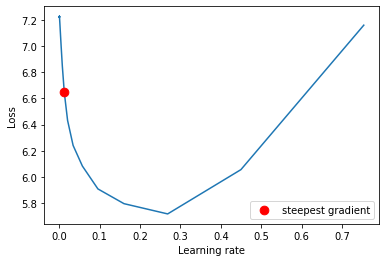

In [14]:
from torch_lr_finder import LRFinder

criterion = torch.nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_dataloader, val_loader=None, end_lr=10, num_iter=50, step_mode="exp")
_, recommended_lr = lr_finder.plot(log_lr=False)
lr_finder.reset()

In [15]:
# model = models.resnet18(pretrained=False)        

# optimizer = torch.optim.SGD([
#     {
#         'name': 'main_model',
#         'params': model.parameters(),
#         'lr': 0.1,
#         'momentum': 0.9,
#         'weight_decay': 1e-4,
#     }
# ])

# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda epoch: 0.1 ** (epoch // 30)
# )

# trainer_io = TrainerIO(
#     log_dir="./logs/", experiment_name="experiment1_lr0.1", 
#     checkpoint_condition=HistoryCondition(
#         'avg.val.acc1', 
#         lambda hist: len(hist) == 1 or hist[-1] > max(hist[:-1])
#     )
# )

# trainer = Trainer(device=device, trainer_io=trainer_io, continue_training=False)

# trainer.fit(
#     model, optimizer, scheduler,
#     start_epoch=0, end_epoch=40
# )

In [16]:
# model = models.resnet18(pretrained=False)        

# optimizer = torch.optim.SGD([
#     {
#         'name': 'main_model',
#         'params': model.parameters(),
#         'lr': 0.02,
#         'momentum': 0.9,
#         'weight_decay': 1e-4,
#     }
# ])

# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda epoch: 0.1 ** (epoch // 30)
# )

# trainer_io = TrainerIO(
#     log_dir="./logs/", experiment_name="experiment1_lr0.02", 
#     checkpoint_condition=HistoryCondition(
#         'avg.val.acc1', 
#         lambda hist: len(hist) == 1 or hist[-1] > max(hist[:-1])
#     )
# )

# trainer = Trainer(device=device, trainer_io=trainer_io, continue_training=False)

# trainer.fit(
#     model, optimizer, scheduler,
#     start_epoch=0, end_epoch=40
# )

In [17]:
model = models.resnet18(pretrained=False)        

optimizer = torch.optim.SGD([
    {
        'name': 'main_model',
        'params': model.parameters(),
        'lr': 0.02,
        'momentum': 0.9,
        'weight_decay': 1e-4,
    }
])

num_epochs = 40
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.02,
    epochs=num_epochs,
    steps_per_epoch=len(train_dataloader)
)

trainer_io = TrainerIO(
    log_dir="./logs/", experiment_name="experiment1_onecycle_lr0.02", 
    checkpoint_condition=HistoryCondition(
        'avg.val.acc1', 
        lambda hist: len(hist) == 1 or hist[-1] > max(hist[:-1])
    )
)

trainer = Trainer(device=device, trainer_io=trainer_io, continue_training=False)

trainer.fit(
    model, optimizer, scheduler,
    start_epoch=0, end_epoch=num_epochs
)

saved meta data {'epoch': 0, 'model': 'epoch_00000.pth', 'scheduler': 'epoch_00000.scheduler.pth', 'optimizer': 'epoch_00000.optimizer.pth'} to logs/experiment1_onecycle_lr0.02/checkpoints/epoch_00000.meta.json
saved meta data {'epoch': 1, 'model': 'epoch_00001.pth', 'scheduler': 'epoch_00001.scheduler.pth', 'optimizer': 'epoch_00001.optimizer.pth'} to logs/experiment1_onecycle_lr0.02/checkpoints/epoch_00001.meta.json
saved meta data {'epoch': 3, 'model': 'epoch_00003.pth', 'scheduler': 'epoch_00003.scheduler.pth', 'optimizer': 'epoch_00003.optimizer.pth'} to logs/experiment1_onecycle_lr0.02/checkpoints/epoch_00003.meta.json
saved meta data {'epoch': 4, 'model': 'epoch_00004.pth', 'scheduler': 'epoch_00004.scheduler.pth', 'optimizer': 'epoch_00004.optimizer.pth'} to logs/experiment1_onecycle_lr0.02/checkpoints/epoch_00004.meta.json
saved meta data {'epoch': 5, 'model': 'epoch_00005.pth', 'scheduler': 'epoch_00005.scheduler.pth', 'optimizer': 'epoch_00005.optimizer.pth'} to logs/experim

In [ ]:
1

In [ ]:
# !rm checkpoints/epoch_00001*
# !rm checkpoints/epoch_00002*
# !rm checkpoints/epoch_00003*
# !rm logs/experiment1/checkpoints/epoch_00004*